In [1]:
import sys; print('Python \t\t{0[0]}.{0[1]}'.format(sys.version_info))
import tensorflow as tf; print('Tensorflow \t{}'.format(tf.__version__))
import keras; print('Keras \t\t{}'.format(keras.__version__))

Python 		3.6
Tensorflow 	1.0.0


Using TensorFlow backend.


Keras 		2.0.3


In [2]:
%matplotlib inline 

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np

In [3]:
#linear regression, with additive noise
f = lambda x, e: 2*x + 3 + e
f_vec =  np.vectorize(f)

In [4]:
samples = 1000
e_data = np.random.normal(0.0, 0.2, samples)
x_data = np.random.rand(samples)
y_data = f_vec(x_data,e_data)

# transform into columns
x_data = x_data.reshape(-1,1)
y_data = y_data.reshape(-1,1)

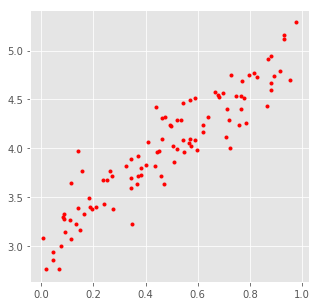

In [5]:
plt.figure(figsize=(5,5))
plt.plot(x_data[:100], y_data[:100], 'r.')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.01, random_state=42)

In [7]:
import tensorflow as tf

In [8]:
# Set parameters
learning_rate = 0.01
training_iteration = 10
batch_size = 5

FLAGS = None

In [9]:
# TF graph input
x = tf.placeholder('float', [None, 1]) 
y = tf.placeholder('float', [None, 1]) 

In [10]:
# Set model weights
w = tf.Variable(tf.zeros([1]), name='w')
b = tf.Variable(tf.zeros([1]), name='b')

In [11]:
with tf.name_scope("wx_b") as scope:
    # Construct a linear model
    y_hat = w*x + b
    
    # Add summary ops to collect data
    tf.summary.histogram("weights", w)
    tf.summary.histogram("biases", b)

In [12]:
# More name scopes will clean up graph representation
with tf.name_scope("cost_function") as scope:
    # Minimize sum squared errors
    cost_function = tf.reduce_sum(tf.pow(y_hat-y,2))
    # Create a summary to monitor the cost function
    tf.summary.scalar("cost_function", cost_function)

In [13]:
with tf.name_scope("train") as scope:
    # Gradient descent
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

In [14]:
# Initializing the variables
init = tf.global_variables_initializer()

# Merge all summaries into a single operator
merged_summary_op = tf.summary.merge_all()

In [15]:
# Launch the graph
sess = tf.InteractiveSession()
sess.run(init)

In [16]:
# Change this to a location on your computer
summary_writer = tf.summary.FileWriter('./tensorboard', graph=sess.graph)

In [17]:
# Training cycle
for iteration in range(training_iteration):
    avg_cost = 0.
    total_batch = int(samples/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_range = slice(batch_size*i,batch_size*(i+1))
        batch_xs = np.copy(x_train[batch_range])
        batch_ys = np.copy(y_train[batch_range])
        
        # Fit training using batch data
        sess.run(optimizer, feed_dict={x : batch_xs, y: batch_ys})
        
        #cost
        cost = sess.run(cost_function, feed_dict={x: batch_xs, y: batch_ys})
        
        # Compute the average loss
        avg_cost += cost/total_batch

        # Write logs for each iteration
        summary_str = sess.run(merged_summary_op, feed_dict={x: batch_xs, y: batch_ys})
        summary_writer.add_summary(summary_str, iteration*total_batch + i)
        
    # Display logs per iteration step
    print("Iteration: {:04d} cost= {:.9f}".format((iteration+1),avg_cost))


Iteration: 0001 cost= 1.532150577
Iteration: 0002 cost= 0.194283060
Iteration: 0003 cost= 0.192620562
Iteration: 0004 cost= 0.192455545
Iteration: 0005 cost= 0.192430744
Iteration: 0006 cost= 0.192425505
Iteration: 0007 cost= 0.192424205
Iteration: 0008 cost= 0.192423897
Iteration: 0009 cost= 0.192423803
Iteration: 0010 cost= 0.192423789


In [18]:
# Calculate accuracy
mse = tf.reduce_mean(tf.pow(y_hat-y,2))
print("Test accuracy (MSE):", mse.eval({x: x_test, y: y_test}))


Test accuracy (MSE): 0.0401259


In [19]:
w_ = w.eval()[0]
b_ = b.eval()[0]
print("Regression a = {:.2}, b = {:.2}".format(w_, b_))

Regression a = 2.0, b = 3.0


In [20]:
y_test_predict = sess.run(y_hat, feed_dict={x:x_test})
np.hstack([x_test[:10], y_test_predict[:10]])

array([[ 0.25185341,  3.48100901],
       [ 0.24564589,  3.46883345],
       [ 0.69684918,  4.35383034],
       [ 0.86998204,  4.69341564],
       [ 0.89885168,  4.75004101],
       [ 0.83513412,  4.62506485],
       [ 0.90368693,  4.7595253 ],
       [ 0.54309404,  4.05225277],
       [ 0.20806884,  3.3951292 ],
       [ 0.14529432,  3.27200246]])

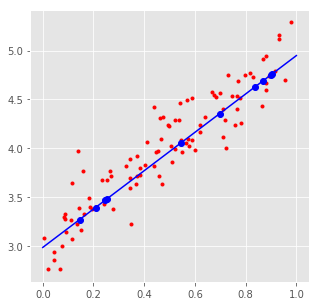

In [21]:
plt.figure(figsize=(5,5))
plt.plot(x_data[:100], y_data[:100], 'r.')
plt.plot(x_test, y_test_predict, 'bo')
plt.plot([b_,w_*1+b_], 'b-')
plt.show()

In [22]:
# Close the Session when we're done.
sess.close()